In [11]:
from numpy import loadtxt
import pandas as pd

#load the data file
data = loadtxt("turbine.dat", skiprows=4)

#convert it to a dataframe using the following fields: height over sea level, fall, net fall, flow, power
df = pd.DataFrame(data, columns=['height', 'fall', 'net_fall', 'flow', 'power'])

#print(df.head)

# Separate the input and output columns
X = df.iloc[:, :-1]  # Select all columns except the last one
y = df.iloc[:, -1]   # Select only the last column

# Split the data into training and testing sets
x_train = X.iloc[:400, :]  # Select the first 400 rows for training
z_train = y.iloc[:400]
x_test = X.iloc[400:, :]   # Select the last 50 rows for testing
z_test = y.iloc[400:]

# print(x_train.shape)
# print(z_train.shape)
# print(x_test.shape)
# print(z_test.shape)
# print(x_train)

In [12]:
# ======= Data Normalization =======

#store the min and the max of each column to denormalize the data later
min_max = {}
for column in df.columns:
    min_max[column] = [df[column].abs().min(), df[column].abs().max()]

# normalize all the data of the dataframe between 0 and 1
df_scaled = df.copy()

#normalize the data between 0 and 1 using the min_max dictionary
for column in df_scaled.columns:
    df_scaled[column] = 0.1 + 0.8 * (df_scaled[column] - min_max[column][0])  / (min_max[column][1] - min_max[column][0])

# Separate the input and output columns
Xs = df_scaled.iloc[:, :-1]  # Select all columns except the last one
ys = df_scaled.iloc[:, -1]   # Select only the last column

# Split the data into training and testing sets
xs_train = Xs.iloc[:400, :]  # Select the first 400 rows for training
zs_train = ys.iloc[:400]
xs_test = Xs.iloc[400:, :]   # Select the last 50 rows for testing
zs_test = ys.iloc[400:]

print(min_max)

{'height': [np.float64(591.0), np.float64(630.0)], 'fall': [np.float64(56.79), np.float64(96.21)], 'net_fall': [np.float64(55.14), np.float64(95.935)], 'flow': [np.float64(3.0), np.float64(9.0)], 'power': [np.float64(1675.16), np.float64(7261.37)]}


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(4, 9)    # First hidden layer with 9 neurons
        self.fc2 = nn.Linear(9, 3)           # Second hidden layer with 3 neurons
        self.fc3 = nn.Linear(3, 1)           # Output layer
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return self.fc3(x)
    
model = MLPNet()

# Mean squared error is commonly used for regression tasks
criterion = nn.MSELoss()

# Using SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=False)
    

In [14]:
# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(xs_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(zs_train.values, dtype=torch.float32).view(-1, 1)  # Reshape if necessary
X_test_tensor = torch.tensor(xs_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(zs_test.values, dtype=torch.float32).view(-1, 1)  # Reshape if necessary

num_epochs = 100

loss_history = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    loss_history.append(loss.item())
    
# Get predictions
with torch.no_grad():
    pred_train_tensor = model(X_train_tensor)
    pred_test_tensor = model(X_test_tensor)
    
# Convert predictions back to arrays of data
pred_train = pred_train_tensor.numpy().flatten()
pred_test = pred_test_tensor.numpy().flatten()

# data denormalization
pred_nn_train = min_max['power'][0] + (pred_train - 0.1) * (min_max['power'][1] - min_max['power'][0]) / 0.8
pred_nn_test = min_max['power'][0] + (pred_test - 0.1) * (min_max['power'][1] - min_max['power'][0]) / 0.8

err_nn_train = 100 * sum(abs(pred_nn_train - z_train)) / sum(z_train)
err_nn_test = 100 * sum(abs(pred_nn_test - z_test)) / sum(z_test)
    

Epoch [1/100], Loss: 0.1432
Epoch [2/100], Loss: 0.0805
Epoch [3/100], Loss: 0.0413
Epoch [4/100], Loss: 0.0652
Epoch [5/100], Loss: 0.1036
Epoch [6/100], Loss: 0.0996
Epoch [7/100], Loss: 0.0621
Epoch [8/100], Loss: 0.0411
Epoch [9/100], Loss: 0.0564
Epoch [10/100], Loss: 0.0783
Epoch [11/100], Loss: 0.0749
Epoch [12/100], Loss: 0.0528
Epoch [13/100], Loss: 0.0411
Epoch [14/100], Loss: 0.0501
Epoch [15/100], Loss: 0.0628
Epoch [16/100], Loss: 0.0609
Epoch [17/100], Loss: 0.0482
Epoch [18/100], Loss: 0.0410
Epoch [19/100], Loss: 0.0459
Epoch [20/100], Loss: 0.0534
Epoch [21/100], Loss: 0.0529
Epoch [22/100], Loss: 0.0456
Epoch [23/100], Loss: 0.0410
Epoch [24/100], Loss: 0.0435
Epoch [25/100], Loss: 0.0480
Epoch [26/100], Loss: 0.0481
Epoch [27/100], Loss: 0.0440
Epoch [28/100], Loss: 0.0410
Epoch [29/100], Loss: 0.0421
Epoch [30/100], Loss: 0.0448
Epoch [31/100], Loss: 0.0452
Epoch [32/100], Loss: 0.0430
Epoch [33/100], Loss: 0.0410
Epoch [34/100], Loss: 0.0414
Epoch [35/100], Loss: 0

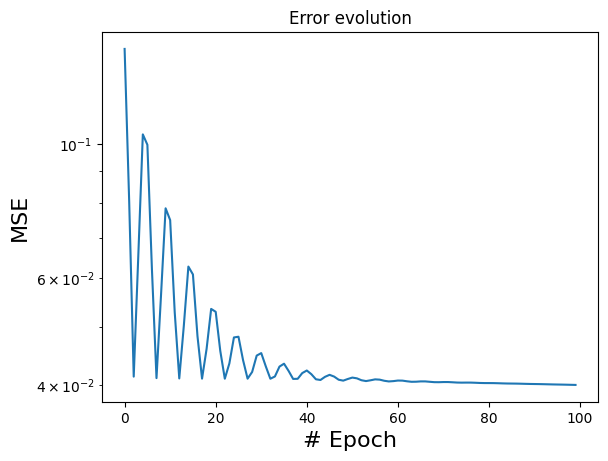

In [15]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(loss_history)
#use a logarithmic scale for the y axis
plt.yscale('log')

plt.title('Error evolution')
plt.ylabel('MSE', fontsize=16)
plt.xlabel('# Epoch', fontsize=16)
plt.show()

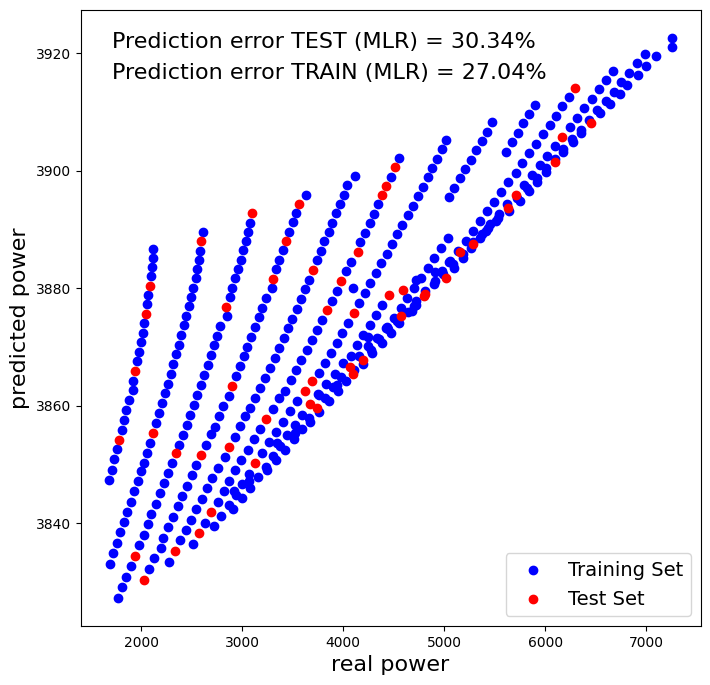

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot the training set scatter with blue color
ax.scatter(z_train, pred_nn_train, c='blue', label='Training Set')

# Plot the test set scatter with red color
ax.scatter(z_test, pred_nn_test, c='red', label='Test Set')

ax.set_xlabel("real power", fontsize=16)
ax.set_ylabel("predicted power", fontsize=16)

ax.text(0.05, 0.9, "Prediction error TEST (MLR) = %.2f%%\n" % err_nn_train, transform=ax.transAxes, fontsize=16)
ax.text(0.05, 0.85, "Prediction error TRAIN (MLR) = %.2f%%\n" % err_nn_test, transform=ax.transAxes, fontsize=16)

# Add a legend to the plot
ax.legend(loc='lower right', fontsize=14)

#fig.savefig("turbine-mlr-test.png", bbox_inches='tight')
plt.show()